In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from matplotlib.ticker import (FuncFormatter, MultipleLocator)


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, \
                                    RandomizedSearchCV, StratifiedShuffleSplit, \
                                    StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, \
                            f1_score, plot_confusion_matrix, confusion_matrix, \
                            plot_roc_curve, classification_report
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag
import spacy
import datetime as dt
import time
import requests

from IPython.core.display import display, HTML

from collections import Counter
import string
import emoji
import pickle
import glob, os
import collections

from sklearn.svm import SVC

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 800

from sklearn.exceptions import NotFittedError
from pathlib import Path

In [31]:
#functions to format all the figures in consistent manner
def format_fig(fig, flag='NotTimeSeries', grid = 'NotFacetGrid'):
    if grid == 'NotFacetGrid':
        fig.suptitle(fig._suptitle.get_text(), fontsize=18, fontweight = 'extra bold', 
                     fontfamily = 'Cambria', color = 'ghostwhite')
        fig.set_facecolor('#00283b')
        axlist = fig.axes
    elif grid == 'FacetGrid':
        fig.fig.suptitle(fig.fig._suptitle.get_text(), fontsize=18, fontweight = 'extra bold', 
                     fontfamily = 'Cambria', color = 'ghostwhite')
        fig.fig.set_facecolor('#00283b')
        axlist = fig.axes.flat
    else:
        pass
    
    
    #loop through all the axes in the figure
    for ax in axlist:
        #ax = ax.get_shared_x_axes().get_siblings(ax)[1] #primary axis location
        ax.grid(False)
        ax.set_facecolor('#00283b')
        ax.tick_params(axis='both', which='both', labelsize=12, labelcolor = 'ghostwhite', color='ghostwhite')
        if flag == 'NotTimeSeries':
            ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
        elif flag == 'TimeSeries':
            axPrimary = ax.get_shared_x_axes().get_siblings(ax)[1]
            axPrimary.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
        elif flag =='NoFormatting':
            pass
        else:
            pass

        ax.xaxis.get_label().set_fontname('Cambria')
        ax.xaxis.get_label().set_fontsize(10)
        ax.xaxis.get_label().set_color('ghostwhite')
        ax.yaxis.get_label().set_fontname('Cambria')
        ax.yaxis.get_label().set_fontsize(10)
        ax.yaxis.get_label().set_color('ghostwhite')

        ax.spines['bottom'].set_color('ghostwhite')
        ax.spines['top'].set_color('ghostwhite') 
        ax.spines['right'].set_color('ghostwhite')
        ax.spines['left'].set_color('ghostwhite')

        ax.set_title(ax.get_title(), fontsize=14, fontweight = 'extra bold', fontfamily = 'Cambria', color = 'ghostwhite')

In [3]:
# Function to generate model reports
def generate_model_report(model, X_train, X_test, y_train, y_test,
                         y_pred, training_score, testing_score):
    labels = ['beyondthebump', 'BabyBumps']
    report = classification_report(y_test, y_pred,
        target_names=labels, output_dict=True)
    report = pd.DataFrame(report).T
    report['support'] = report.support.apply(int)
    print(f'Model results for:- {model}')
    display(report.style.background_gradient(cmap='viridis',
                             subset=pd.IndexSlice['beyondthebump':'BabyBumps', :'f1-score']))
#     print(report)
    print("Training Accuracy Score: {:0.3f}".format(training_score))
    print("Test Accuracy Score: {:0.3f}".format(testing_score))
    

    
    

In [76]:
def pretty_confusion_matrix(y_true, y_pred):
    # handling data
    cm = confusion_matrix(y_true, y_pred)
    labels = ['beyondthebump', 'BabyBumps']
    pred_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    
    # plotting
    sns.set(font_scale=1.2)
    fig, ax = plt.subplots(figsize=(10,4))
    
    sns.heatmap(cm, annot=True, fmt='g', cmap="YlGnBu",
                xticklabels=labels, yticklabels=labels, ax=ax,
                annot_kws={"size": 15})

    fig.suptitle("Confusion Matrix")

    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')
    
    for i, txt in enumerate(ax.texts):
        txt.set_text(f'{pred_labels[i]}={txt.get_text()}')
        
    format_fig(fig, flag='NoFormatting', grid = 'NotFacetGrid')

In [5]:
def word_split(text):
    #print (text)
    # split into words by white space
    words = text.split()
    # remove punctuation from each word
    #table = str.maketrans('', '', '''!"#$%&'()*+,.:;<=>?@[\]^_`{|}~''')
    table = str.maketrans('', '', string.punctuation)

    stripped = [w.lower().translate(table) for w in words]
    return list(filter(None, stripped))  # there were empty strings in the list where the text contained space followed \
                                        # by a period followed by a space '_._'

In [6]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_split(doc)]

In [7]:
class PorterStemming:
    def __init__(self):
        self.pst = PorterStemmer()
    def __call__(self, doc):
        return [self.pst.stem(t) for t in word_split(doc)]

In [8]:
# Instantiate PorterStemmer.
p_stemmer = PorterStemmer()

In [9]:
table = str.maketrans('', '', string.punctuation)
p_stemmer_stopwords = [w.lower().translate(table) for w in stopwords.words("english")]
p_stemmer_stopwords = [p_stemmer.stem(i) for i in p_stemmer_stopwords]

In [10]:
df = pd.read_csv('../data/df.csv', index_col=0)
df.reset_index(drop=True, inplace=True)

In [225]:
X = df['title'] + ' ' + df['selftext']
y = df['subreddit'].map({'beyondthebump':0, 'BabyBumps':1})

In [226]:
# Define training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [227]:
# Baseline Accuracy
y_train.value_counts(normalize=True)

0    0.586149
1    0.413851
Name: subreddit, dtype: float64

## **Fitting and Saving All the Model Results**

In [145]:
model_dict = collections.defaultdict(dict)
path = "../models"
model_files = [f for f in os.listdir(path) if f.endswith('.sav')]
for file in model_files:
    filename = os.path.join(path, file)
    filename_stem = Path(filename).stem
    file = open(filename ,'rb')
    try: 
        model = pickle.load(file)
        y_pred = model.predict(X_test)   
        print (f'Fitting and Saving Model Results for:- {filename_stem}')
        training_score = model.score(X_train, y_train)
        testing_score = model.score(X_test, y_test)
        model_dict[filename_stem]['y_pred'] = y_pred
        model_dict[filename_stem]['training_score'] = training_score
        model_dict[filename_stem]['testing_score'] = testing_score
    except EOFError:
        print(f'Model file was not saved properly. Reports cannot be generated:- {filename_stem}')
    except NotFittedError:
        print(f'Model was not fitted. Reports cannot be generated:- {filename_stem}')
#     generate_model_report(model, X_train, X_test, y_train, y_test)

Fitting and Saving Model Results for:- svc_cv_v2
Fitting and Saving Model Results for:- mnb_gs_v1
Fitting and Saving Model Results for:- svc_cv_v1
Fitting and Saving Model Results for:- mnb_gs_v3
Fitting and Saving Model Results for:- mnb_gs_v2
Fitting and Saving Model Results for:- logreg_gs
Fitting and Saving Model Results for:- logreg_gs_v9
Fitting and Saving Model Results for:- mnb_gs_v5
Fitting and Saving Model Results for:- mnb_gs_v4
Fitting and Saving Model Results for:- rscv_v2
Fitting and Saving Model Results for:- rscv_v1
Model was not fitted. Reports cannot be generated:- logreg_gs_v7
Fitting and Saving Model Results for:- logreg_gs_v14
Fitting and Saving Model Results for:- logreg_gs_v15
Fitting and Saving Model Results for:- logreg_gs_v6
Fitting and Saving Model Results for:- logreg_gs_v4
Fitting and Saving Model Results for:- logreg_gs_v5
Fitting and Saving Model Results for:- logreg_gs_v12
Fitting and Saving Model Results for:- logreg_gs_v13
Fitting and Saving Model Resu

## **Scoring and Generating Classification Reports for All Saved Models**

In [228]:
model_alias_dict = collections.defaultdict(dict)
model_alias_dict['logreg'] = 'LogisticRegression'
model_alias_dict['svc'] = 'SVC'
model_alias_dict['rscv'] = 'RandomForestClassifier'
model_alias_dict['mnb'] = 'MultinomialNB'

In [229]:
model_scores = []
for key in model_dict.keys():
    
    y_pred = model_dict[key]['y_pred']
    training_score = model_dict[key]['training_score']
    testing_score = model_dict[key]['testing_score']
    generate_model_report(key, X_train, X_test, y_train, y_test,
                         y_pred, training_score, testing_score)
    model_alias = model_alias_dict[key.split('_')[0]]
    model_version = re.match('.*v(.*)', key)
    if model_version == None:
        model_alias = model_alias + '-' + str(0)
    else:
        model_alias = model_alias + '-' + str(model_version[1])
    model_scores.append([model_alias, training_score, testing_score])
model_scores_df = pd.DataFrame(model_scores, columns=['Model Alias', 'Training Score', 'Testing Score'])
model_scores_df.sort_values(by=['Training Score'], ascending=False,inplace=True)
model_scores_df.set_index(keys='Model Alias', inplace=True)
model_scores_df

Model results for:- svc_cv_v2


,precision,recall,f1-score,support
beyondthebump,0.837198,0.844954,0.841058,2051
BabyBumps,0.777467,0.767265,0.772332,1448
accuracy,0.812804,0.812804,0.812804,0
macro avg,0.807332,0.806109,0.806695,3499
weighted avg,0.812479,0.812804,0.812617,3499


Training Accuracy Score: 0.991
Test Accuracy Score: 0.813
Model results for:- mnb_gs_v1


,precision,recall,f1-score,support
beyondthebump,0.805137,0.886397,0.843815,2051
BabyBumps,0.812248,0.696133,0.749721,1448
accuracy,0.807659,0.807659,0.807659,0
macro avg,0.808693,0.791265,0.796768,3499
weighted avg,0.808080,0.807659,0.804876,3499


Training Accuracy Score: 0.852
Test Accuracy Score: 0.808
Model results for:- svc_cv_v1


,precision,recall,f1-score,support
beyondthebump,0.834555,0.887860,0.860383,2051
BabyBumps,0.825361,0.750691,0.786257,1448
accuracy,0.831095,0.831095,0.831095,0
macro avg,0.829958,0.819275,0.823320,3499
weighted avg,0.830750,0.831095,0.829707,3499


Training Accuracy Score: 0.938
Test Accuracy Score: 0.831
Model results for:- mnb_gs_v3


,precision,recall,f1-score,support
beyondthebump,0.805137,0.886397,0.843815,2051
BabyBumps,0.812248,0.696133,0.749721,1448
accuracy,0.807659,0.807659,0.807659,0
macro avg,0.808693,0.791265,0.796768,3499
weighted avg,0.808080,0.807659,0.804876,3499


Training Accuracy Score: 0.852
Test Accuracy Score: 0.808
Model results for:- mnb_gs_v2


,precision,recall,f1-score,support
beyondthebump,0.805137,0.886397,0.843815,2051
BabyBumps,0.812248,0.696133,0.749721,1448
accuracy,0.807659,0.807659,0.807659,0
macro avg,0.808693,0.791265,0.796768,3499
weighted avg,0.808080,0.807659,0.804876,3499


Training Accuracy Score: 0.852
Test Accuracy Score: 0.808
Model results for:- logreg_gs


,precision,recall,f1-score,support
beyondthebump,0.841882,0.872257,0.856801,2051
BabyBumps,0.809316,0.767956,0.788094,1448
accuracy,0.829094,0.829094,0.829094,0
macro avg,0.825599,0.820107,0.822447,3499
weighted avg,0.828405,0.829094,0.828367,3499


Training Accuracy Score: 0.962
Test Accuracy Score: 0.768
Model results for:- logreg_gs_v9


,precision,recall,f1-score,support
beyondthebump,0.856212,0.897123,0.876190,2051
BabyBumps,0.843704,0.786602,0.814153,1448
accuracy,0.851386,0.851386,0.851386,0
macro avg,0.849958,0.841863,0.845172,3499
weighted avg,0.851036,0.851386,0.850517,3499


Training Accuracy Score: 0.946
Test Accuracy Score: 0.851
Model results for:- mnb_gs_v5


,precision,recall,f1-score,support
beyondthebump,0.837296,0.875670,0.856053,2051
BabyBumps,0.811669,0.758978,0.784440,1448
accuracy,0.827379,0.827379,0.827379,0
macro avg,0.824483,0.817324,0.820247,3499
weighted avg,0.826691,0.827379,0.826417,3499


Training Accuracy Score: 0.871
Test Accuracy Score: 0.827
Model results for:- mnb_gs_v4


,precision,recall,f1-score,support
beyondthebump,0.840074,0.881034,0.860067,2051
BabyBumps,0.818991,0.762431,0.789700,1448
accuracy,0.831952,0.831952,0.831952,0
macro avg,0.829533,0.821732,0.824883,3499
weighted avg,0.831349,0.831952,0.830946,3499


Training Accuracy Score: 0.859
Test Accuracy Score: 0.832
Model results for:- rscv_v2


,precision,recall,f1-score,support
beyondthebump,0.842034,0.904437,0.872120,2051
BabyBumps,0.848765,0.759669,0.801749,1448
accuracy,0.844527,0.844527,0.844527,0
macro avg,0.845400,0.832053,0.836935,3499
weighted avg,0.844819,0.844527,0.842999,3499


Training Accuracy Score: 0.998
Test Accuracy Score: 0.845
Model results for:- rscv_v1


,precision,recall,f1-score,support
beyondthebump,0.840961,0.904924,0.871771,2051
BabyBumps,0.849071,0.757597,0.800730,1448
accuracy,0.843955,0.843955,0.843955,0
macro avg,0.845016,0.831261,0.836250,3499
weighted avg,0.844317,0.843955,0.842372,3499


Training Accuracy Score: 0.998
Test Accuracy Score: 0.844
Model results for:- logreg_gs_v14


,precision,recall,f1-score,support
beyondthebump,0.825034,0.896636,0.859346,2051
BabyBumps,0.833071,0.730663,0.778514,1448
accuracy,0.827951,0.827951,0.827951,0
macro avg,0.829052,0.813649,0.818930,3499
weighted avg,0.828360,0.827951,0.825895,3499


Training Accuracy Score: 0.861
Test Accuracy Score: 0.828
Model results for:- logreg_gs_v15


,precision,recall,f1-score,support
beyondthebump,0.854621,0.897123,0.875357,2051
BabyBumps,0.843239,0.783840,0.812455,1448
accuracy,0.850243,0.850243,0.850243,0
macro avg,0.848930,0.840482,0.843906,3499
weighted avg,0.849911,0.850243,0.849326,3499


Training Accuracy Score: 0.852
Test Accuracy Score: 0.850
Model results for:- logreg_gs_v6


,precision,recall,f1-score,support
beyondthebump,0.855680,0.896148,0.875447,2051
BabyBumps,0.842339,0.785912,0.813148,1448
accuracy,0.850529,0.850529,0.850529,0
macro avg,0.849009,0.841030,0.844297,3499
weighted avg,0.850159,0.850529,0.849665,3499


Training Accuracy Score: 0.854
Test Accuracy Score: 0.851
Model results for:- logreg_gs_v4


,precision,recall,f1-score,support
beyondthebump,0.854460,0.887372,0.870605,2051
BabyBumps,0.831264,0.785912,0.807952,1448
accuracy,0.845384,0.845384,0.845384,0
macro avg,0.842862,0.836642,0.839278,3499
weighted avg,0.844861,0.845384,0.844677,3499


Training Accuracy Score: 0.844
Test Accuracy Score: 0.845
Model results for:- logreg_gs_v5


,precision,recall,f1-score,support
beyondthebump,0.855680,0.896148,0.875447,2051
BabyBumps,0.842339,0.785912,0.813148,1448
accuracy,0.850529,0.850529,0.850529,0
macro avg,0.849009,0.841030,0.844297,3499
weighted avg,0.850159,0.850529,0.849665,3499


Training Accuracy Score: 0.854
Test Accuracy Score: 0.851
Model results for:- logreg_gs_v12


,precision,recall,f1-score,support
beyondthebump,0.838262,0.884447,0.860735,2051
BabyBumps,0.822472,0.758287,0.789077,1448
accuracy,0.832238,0.832238,0.832238,0
macro avg,0.830367,0.821367,0.824906,3499
weighted avg,0.831728,0.832238,0.831081,3499


Training Accuracy Score: 0.851
Test Accuracy Score: 0.832
Model results for:- logreg_gs_v13


,precision,recall,f1-score,support
beyondthebump,0.828755,0.882496,0.854782,2051
BabyBumps,0.816730,0.741713,0.777416,1448
accuracy,0.824235,0.824235,0.824235,0
macro avg,0.822742,0.812105,0.816099,3499
weighted avg,0.823778,0.824235,0.822765,3499


Training Accuracy Score: 0.844
Test Accuracy Score: 0.824
Model results for:- logreg_gs_v2


,precision,recall,f1-score,support
beyondthebump,0.834336,0.879083,0.856125,2051
BabyBumps,0.814649,0.752762,0.782484,1448
accuracy,0.826808,0.826808,0.826808,0
macro avg,0.824492,0.815923,0.819305,3499
weighted avg,0.826189,0.826808,0.825650,3499


Training Accuracy Score: 0.772
Test Accuracy Score: 0.753
Model results for:- logreg_gs_v11


,precision,recall,f1-score,support
beyondthebump,0.838262,0.884447,0.860735,2051
BabyBumps,0.822472,0.758287,0.789077,1448
accuracy,0.832238,0.832238,0.832238,0
macro avg,0.830367,0.821367,0.824906,3499
weighted avg,0.831728,0.832238,0.831081,3499


Training Accuracy Score: 0.851
Test Accuracy Score: 0.832
Model results for:- logreg_gs_v10


,precision,recall,f1-score,support
beyondthebump,0.856212,0.897123,0.876190,2051
BabyBumps,0.843704,0.786602,0.814153,1448
accuracy,0.851386,0.851386,0.851386,0
macro avg,0.849958,0.841863,0.845172,3499
weighted avg,0.851036,0.851386,0.850517,3499


Training Accuracy Score: 0.946
Test Accuracy Score: 0.851
Model results for:- logreg_gs_v3


,precision,recall,f1-score,support
beyondthebump,0.854059,0.887372,0.870397,2051
BabyBumps,0.831140,0.785221,0.807528,1448
accuracy,0.845099,0.845099,0.845099,0
macro avg,0.842600,0.836297,0.838963,3499
weighted avg,0.844575,0.845099,0.844380,3499


Training Accuracy Score: 0.844
Test Accuracy Score: 0.845


,Training Score,Testing Score
Model Alias,,
RandomForestClassifier-1,0.998170,0.843955
RandomForestClassifier-2,0.997889,0.844527
SVC-2,0.990709,0.812804
LogisticRegression-0,0.961565,0.767956
LogisticRegression-10,0.946087,0.851386
LogisticRegression-9,0.946087,0.851386
SVC-1,0.938345,0.831095
MultinomialNB-5,0.870918,0.827379
LogisticRegression-14,0.861205,0.827951


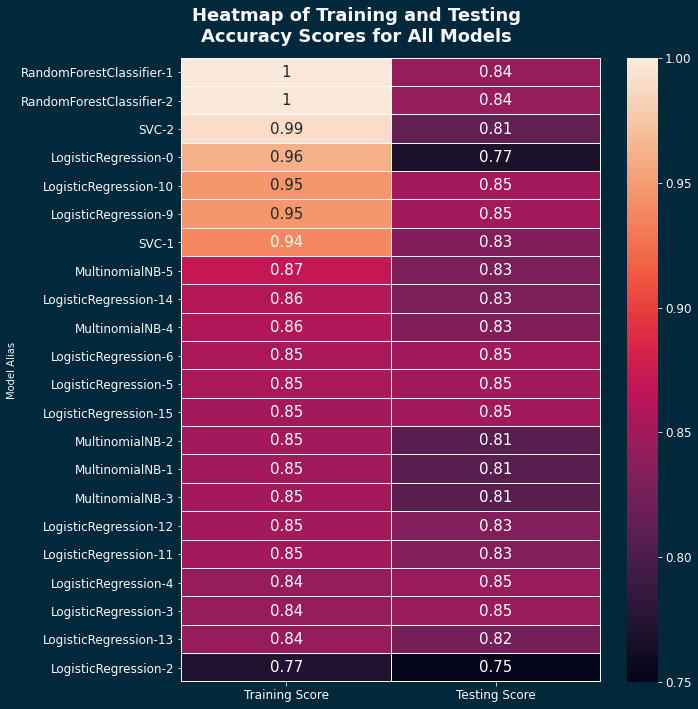

In [231]:
fig, ax = plt.subplots(figsize=(10, 10))
cmap = sns.cm.rocket
sns.heatmap(data=model_scores_df, annot=True, annot_kws={"fontsize":15}, ax=ax, 
            linewidths=.05, linecolor='ghostwhite', cmap=cmap,
           vmin=0.75, vmax=1);
fig.suptitle('Heatmap of Training and Testing\nAccuracy Scores for All Models')
format_fig(fig = fig, flag = 'NoFormatting', grid = 'NotFacetGrid')
plt.tight_layout()

## **Refitting the LogisticRegression-6 model on Originally Cleaned Dataset**

In [232]:
path = "../models"
file = 'logreg_gs_v6.sav'
filename = os.path.join(path, file)
filename_stem = Path(filename).stem
file = open(filename ,'rb')
model = pickle.load(file)


In [233]:
logreg_coef = model.best_estimator_[1].coef_

In [234]:
logreg_columns = model.best_estimator_[0].get_feature_names()

In [235]:
logreg_coef_df = pd.DataFrame(logreg_coef, columns=logreg_columns)

In [236]:
logreg_coef_df

,,,1,2,3,4,also,anyon,babi,cant,...,youtub video,yr,yr old,zero,zip,zipper,zofran,zoloft,zombi,zone
0,0.35365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [237]:
y_pred = model.predict(X_test)  

In [238]:
cvec = model.best_estimator_[0]
clf = model.best_estimator_[1]
logreg = make_pipeline(cvec, clf)

In [239]:
logreg.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.6, max_features=7500, min_df=0,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             'your', 'youv', 'youll', 'youd',
                                             'your', 'your', 'yourself',
                                             'yourselv', 'he', 'him', 'hi',
                                             'himself', 'she', 'she', 'her',
                                             'her', 'herself', 'it', 'it', 'it',
                                             'itself', ...],
                                 tokenizer=<__main__.PorterStemming object at 0x7ff0f2345ac0>)),
                ('logisticregressioncv',
                 LogisticRegressionCV(Cs=array([1.00000000e-04, 3.59381366e-04, 1.29154967e-03, 4.

In [240]:
logreg.score(X_train, y_train), logreg.score(X_test, y_test)

(0.8558558558558559, 0.8499571306087453)

In [241]:
coef_cols = cvec.get_feature_names()

In [242]:
coef_vals = clf.coef_[0]

In [243]:
logreg_coef_df = pd.DataFrame(coef_vals, index=coef_cols, columns=['Coeff']). \
                                sort_values(by='Coeff', key = abs, ascending=False).head(25)

In [244]:
logreg_coef_df = logreg_coef_df[logreg_coef_df['Coeff'] != 0].sort_values(by='Coeff', ascending=False)

In [245]:
len(logreg_coef_df)

25

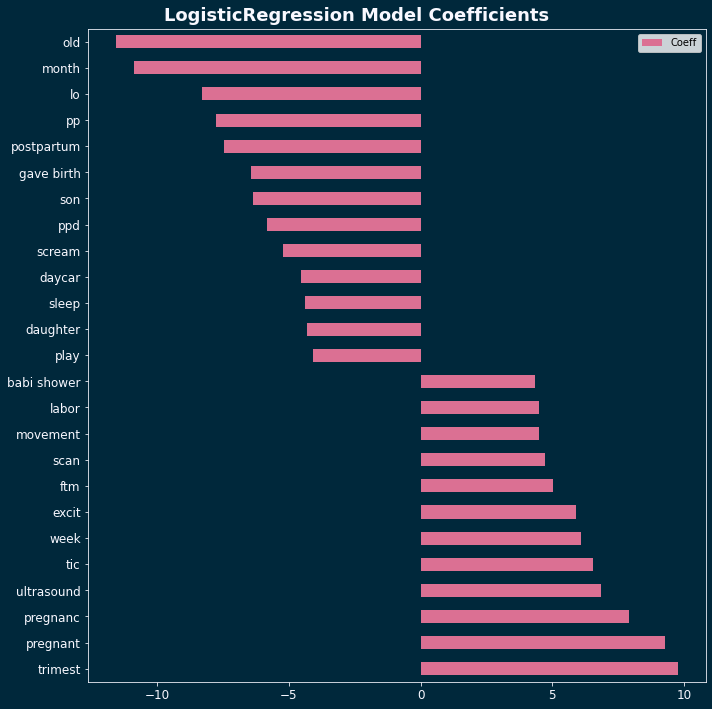

In [246]:
fig, ax = plt.subplots(figsize=(10, 10))
cmap = sns.cm.rocket
logreg_coef_df.plot.barh(color='palevioletred', ax=ax)
fig.suptitle('LogisticRegression Model Coefficients')
format_fig(fig = fig, flag = 'NoFormatting', grid = 'NotFacetGrid')
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# logreg_coef_df.plot.barh(figsize=(7,60));

In [247]:
logreg_coef_df.index

Index(['trimest', 'pregnant', 'pregnanc', 'ultrasound', 'tic', 'week', 'excit',
       'ftm', 'scan', 'movement', 'labor', 'babi shower', 'play', 'daughter',
       'sleep', 'daycar', 'scream', 'ppd', 'son', 'gave birth', 'postpartum',
       'pp', 'lo', 'month', 'old'],
      dtype='object')

## **Refitting the LogisticRegression-6 model after Additional Text Cleaning**

After evaluating model results from earlier iterations, additional text cleaning was done

In [11]:
def clean_text(X):
    X = ' '.join(list(filter(None,re.split('(\d+)', X))))
    X = re.sub('(hrs)', 'hour', X)
    X = re.sub('\s+(h)\s+', ' hour ', X)
    X = re.sub('(hr)', 'hour', X)
    X = re.sub('(lbs)', 'lb', X)
    X = re.sub('(mins)', 'min', X)
    X = re.sub('(mls)', 'ml', X)
    X = re.sub('\s+(mos)\s+', ' month ', X)
    X = re.sub('\s+(mo)\s+', ' month ', X)
    X = re.sub('\s+(p)\s+', ' pm ', X)
    X = re.sub('\s+(w)\s+', ' week ', X)
    X = re.sub('\s+(d)\s+', ' day ', X)
    X = re.sub('(wks)', 'week', X)
    X = re.sub('(wk)', 'week', X)
    X = re.sub('yrs', 'year', X)
    X = re.sub('yr', 'year', X)
    X = re.sub('\s+(y)\s+', ' year ', X)
    X = re.sub('yo', 'year old', X)
    X = re.sub('\s+(f)\s+', ' female ', X)
    X = re.sub('(\d+)\s+\.\s+(\d+\s+)', r'\1.\2', X)
    return X

In [12]:
X = df['title'] + ' ' + df['selftext']
y = df['subreddit'].map({'beyondthebump':0, 'BabyBumps':1})

In [13]:
X = X.apply(clean_text)

In [14]:
# Define training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [69]:
path = "../models"
file = 'logreg_gs_v15.sav'
filename = os.path.join(path, file)
filename_stem = Path(filename).stem
file = open(filename ,'rb')
model = pickle.load(file)


In [70]:
model[1]

LogisticRegressionCV(Cs=array([1.00000000e-04, 3.59381366e-04, 1.29154967e-03, 4.64158883e-03,
       1.66810054e-02, 5.99484250e-02, 2.15443469e-01, 7.74263683e-01,
       2.78255940e+00, 1.00000000e+01]),
                     max_iter=1000, penalty='l1', scoring='accuracy',
                     solver='liblinear')

In [71]:
logreg_coef = model[1].coef_

In [72]:
logreg_columns = model[0].get_feature_names()

In [73]:
logreg_coef_df = pd.DataFrame(logreg_coef, columns=logreg_columns)

In [74]:
logreg_coef_df

,0,00,00 pm,000,1,1 1,1 2,1 3,1 30,1 cm,...,yet anoth,yet im,yo,youtub,zero,zip,zipper,zofran,zoloft,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
y_pred = model.predict(X_test)  

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['becau'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [22]:
cvec = model[0]
clf = model[1]
logreg = make_pipeline(cvec, clf)

In [23]:
logreg.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.6, max_features=7500, min_df=0,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             'your', 'youv', 'youll', 'youd',
                                             'your', 'your', 'yourself',
                                             'yourselv', 'he', 'him', 'hi',
                                             'himself', 'she', 'she', 'her',
                                             'her', 'herself', 'it', 'it', 'it',
                                             'itself', ...],
                                 tokenizer=<__main__.PorterStemming object at 0x7f8a2c27cf40>)),
                ('logisticregressioncv',
                 LogisticRegressionCV(Cs=array([1.00000000e-04, 3.59381366e-04, 1.29154967e-03, 4.

In [24]:
logreg.score(X_train, y_train), logreg.score(X_test, y_test)

(0.8555743243243243, 0.8536724778508146)

In [25]:
coef_cols = cvec.get_feature_names()

In [26]:
coef_vals = clf.coef_[0]

In [27]:
logreg_coef_df = pd.DataFrame(coef_vals, index=coef_cols, columns=['Coeff']). \
                                sort_values(by='Coeff', key = abs, ascending=False).head(25)

In [28]:
logreg_coef_df = logreg_coef_df[logreg_coef_df['Coeff'] != 0].sort_values(by='Coeff', ascending=False)

In [29]:
len(logreg_coef_df)

25

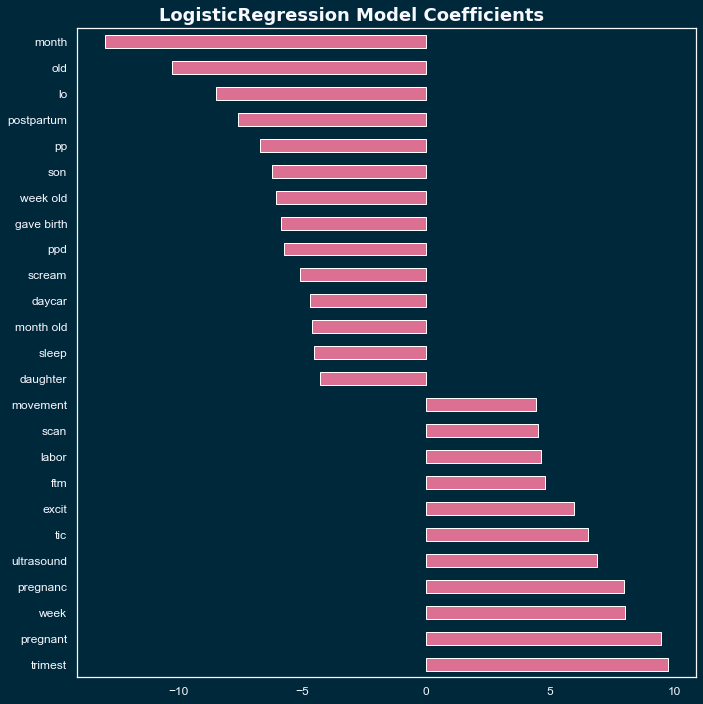

In [66]:
fig, ax = plt.subplots(figsize=(10, 10))
cmap = sns.cm.rocket
logreg_coef_df.plot.barh(color='palevioletred', ax=ax)
fig.suptitle('LogisticRegression Model Coefficients')
format_fig(fig = fig, flag = 'NoFormatting', grid = 'NotFacetGrid')
ax.get_legend().remove()
plt.tight_layout()
plt.subplots_adjust(top=0.95)


In [33]:
logreg_coef_df.index

Index(['trimest', 'pregnant', 'week', 'pregnanc', 'ultrasound', 'tic', 'excit',
       'ftm', 'labor', 'scan', 'movement', 'daughter', 'sleep', 'month old',
       'daycar', 'scream', 'ppd', 'gave birth', 'week old', 'son', 'pp',
       'postpartum', 'lo', 'old', 'month'],
      dtype='object')

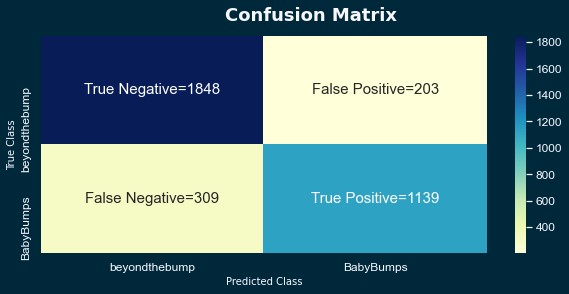

In [77]:
pretty_confusion_matrix(y_test, y_pred)

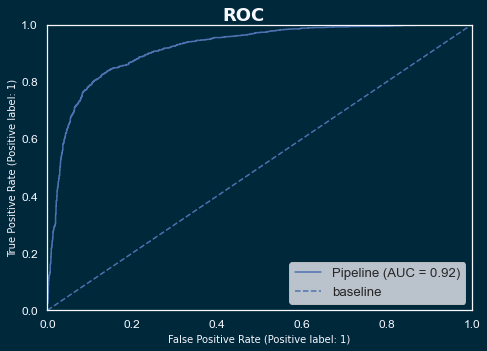

In [48]:
fig, ax = plt.subplots(figsize=(7, 5))
plot_roc_curve(logreg, X_test, y_test, ax=ax)
ax.axline([0, 0], [1, 1],
         label='baseline', linestyle='--')
plt.legend();
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
fig.suptitle('ROC')
format_fig(fig = fig, flag = 'NoFormatting', grid = 'NotFacetGrid')
plt.tight_layout()
plt.subplots_adjust(top=0.93)

In [79]:
confusion_matrix(y_test, y_pred).ravel()

array([1848,  203,  309, 1139])

In [80]:
labels = ['beyondthebump', 'BabyBumps']
report = classification_report(y_test, y_pred,
    target_names=labels, output_dict=True)
report = pd.DataFrame(report).T
report['support'] = report.support.apply(int)
display(report.style.background_gradient(cmap='viridis',
                         subset=pd.IndexSlice['beyondthebump':'BabyBumps', :'f1-score']))

,precision,recall,f1-score,support
beyondthebump,0.856745,0.901024,0.878327,2051
BabyBumps,0.848733,0.786602,0.816487,1448
accuracy,0.853672,0.853672,0.853672,0
macro avg,0.852739,0.843813,0.847407,3499
weighted avg,0.853430,0.853672,0.852736,3499


In [110]:
classification_metrics = report.loc[['beyondthebump','BabyBumps'], ['precision','recall', 'f1-score']]

In [111]:
display(classification_metrics.style.background_gradient(cmap='viridis',
                         subset=pd.IndexSlice['beyondthebump':'BabyBumps', :'f1-score']))

,precision,recall,f1-score
beyondthebump,0.856745,0.901024,0.878327
BabyBumps,0.848733,0.786602,0.816487


In [99]:
classification_metrics

,precision,recall,f1-score
beyondthebump,0.856745,0.901024,0.878327
BabyBumps,0.848733,0.786602,0.816487


In [100]:
classification_metrics = classification_metrics.reset_index().melt(id_vars=["index"],
                                                                  var_name='Metric',
                                                                   value_name='Score'
                                                                  )

In [102]:
classification_metrics.rename(columns={'index':'subreddit'}, inplace=True)

In [103]:
classification_metrics

,subreddit,Metric,Score
0,beyondthebump,precision,0.856745
1,BabyBumps,precision,0.848733
2,beyondthebump,recall,0.901024
3,BabyBumps,recall,0.786602
4,beyondthebump,f1-score,0.878327
5,BabyBumps,f1-score,0.816487


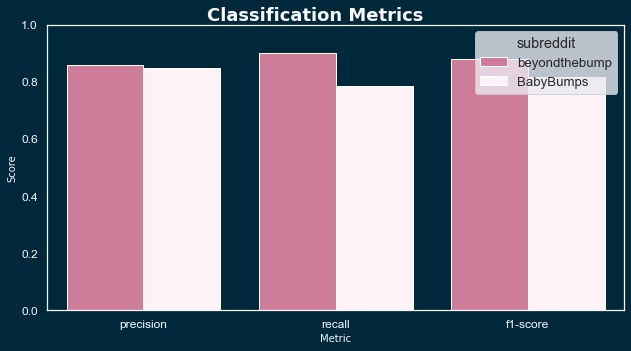

In [109]:
fig, ax = plt.subplots(figsize=(9, 5))
sns.barplot(data=classification_metrics, y='Score', x='Metric', hue='subreddit',
            palette = ['palevioletred', 'lavenderblush'],ax=ax)

fig.suptitle('Classification Metrics')
ax.set_ylim([0,1])
format_fig(fig = fig, flag = 'NoFormatting', grid = 'NotFacetGrid')
plt.tight_layout()
plt.subplots_adjust(top=0.93)



## **Additional Cleaning of Data and Fitting LogisticRegression**

In [119]:
def clean_text(X):
    X = ' '.join(list(filter(None,re.split('(\d+)', X))))
    X = re.sub('(hrs)', 'hour', X)
    X = re.sub('\s+(h)\s+', ' hour ', X)
    X = re.sub('(hr)', 'hour', X)
    X = re.sub('(lbs)', 'lb', X)
    X = re.sub('(mins)', 'min', X)
    X = re.sub('(mls)', 'ml', X)
    X = re.sub('\s+(mos)\s+', ' month ', X)
    X = re.sub('\s+(mo)\s+', ' month ', X)
    X = re.sub('\s+(p)\s+', ' pm ', X)
    X = re.sub('\s+(w)\s+', ' week ', X)
    X = re.sub('\s+(d)\s+', ' day ', X)
    X = re.sub('(wks)', 'week', X)
    X = re.sub('(wk)', 'week', X)
    X = re.sub('yrs', 'year', X)
    X = re.sub('yr', 'year', X)
    X = re.sub('\s+(y)\s+', ' year ', X)
    X = re.sub('yo', 'year old', X)
    X = re.sub('\s+(f)\s+', ' female ', X)
    X = re.sub('(\d+)\s+\.\s+(\d+\s+)', r'\1.\2', X)
    return X

In [120]:
X = df['title'] + ' ' + df['selftext']
y = df['subreddit'].map({'beyondthebump':0, 'BabyBumps':1})

In [121]:
X = X.apply(clean_text)

In [122]:
# Define training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

### Using the logisticregression-6 model params which was the best model based on earlier less clean data to fit the newly clean data

In [123]:
path = "../models"
file = 'logreg_gs_v6.sav'
filename = os.path.join(path, file)
filename_stem = Path(filename).stem
file = open(filename ,'rb')
model = pickle.load(file)

In [124]:
cvec = model.best_estimator_[0]
clf = model.best_estimator_[1]
logreg = make_pipeline(cvec, clf)

In [125]:
logreg.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.6, max_features=7500, min_df=0,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             'your', 'youv', 'youll', 'youd',
                                             'your', 'your', 'yourself',
                                             'yourselv', 'he', 'him', 'hi',
                                             'himself', 'she', 'she', 'her',
                                             'her', 'herself', 'it', 'it', 'it',
                                             'itself', ...],
                                 tokenizer=<__main__.PorterStemming object at 0x7ff1202ef640>)),
                ('logisticregressioncv',
                 LogisticRegressionCV(Cs=array([1.00000000e-04, 3.59381366e-04, 1.29154967e-03, 4.

In [126]:
logreg.score(X_train, y_train), logreg.score(X_test, y_test)

(0.8555743243243243, 0.8536724778508146)

In [127]:
coef_cols = cvec.get_feature_names()

In [128]:
coef_vals = clf.coef_[0]

In [129]:
logreg_coef_df = pd.DataFrame(coef_vals, index=coef_cols, columns=['Coeff']).sort_values(by='Coeff', ascending=False)

In [130]:
logreg_coef_df = logreg_coef_df[logreg_coef_df['Coeff'] != 0]

In [131]:
len(logreg_coef_df)

208

In [133]:
filename = '../models/logreg_gs_v15.sav'
pickle.dump(logreg, open(filename, 'wb'))  #cleaned up X used for modeling, not a gridsearch

# (0.8555743243243243, 0.8536724778508146)

### Gridsearch using LogisticRegression using newly cleaned Data

In [91]:

logreg_pipe = Pipeline([
    ('tvec', CountVectorizer(stop_words=p_stemmer_stopwords, tokenizer=PorterStemming()) ),
    ('logreg', LogisticRegressionCV(scoring='accuracy', max_iter=1000,
    Cs = np.logspace(-4,1,10)))])

In [93]:
logreg_pipe_params = {
    'tvec__min_df': [0.01, 0.02,0.03, 0.05], #,0.1, 0.02, 0.03, 0.04, 0.05,0.075,0.1],
    'tvec__max_df': [0.5,0.6,0.7,0.8],
    'tvec__ngram_range': [(1,2), (1,3)], #[(1,1), (1,2), (1,3), (1,4)],
    'logreg__penalty' : ['l2']
}

In [96]:
# Instantiate GridSearchCV.

logreg_gs = RandomizedSearchCV(logreg_pipe, # what object are we optimizing?
                               logreg_pipe_params, # what parameters values are we searching?
                               cv = 5, # 5-fold cross-validation.
                              n_iter = 350,
                              verbose=3) 

In [97]:
# Fit GridSearch to training data.
import warnings
#warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
logreg_gs.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END logreg__penalty=l2, tvec__max_df=0.5, tvec__min_df=0.01, tvec__ngram_range=(1, 2); total time=  17.5s
[CV 2/5] END logreg__penalty=l2, tvec__max_df=0.5, tvec__min_df=0.01, tvec__ngram_range=(1, 2); total time=  17.3s
[CV 3/5] END logreg__penalty=l2, tvec__max_df=0.5, tvec__min_df=0.01, tvec__ngram_range=(1, 2); total time=  17.1s
[CV 4/5] END logreg__penalty=l2, tvec__max_df=0.5, tvec__min_df=0.01, tvec__ngram_range=(1, 2); total time=  17.4s
[CV 5/5] END logreg__penalty=l2, tvec__max_df=0.5, tvec__min_df=0.01, tvec__ngram_range=(1, 2); total time=  17.3s
[CV 1/5] END logreg__penalty=l2, tvec__max_df=0.5, tvec__min_df=0.01, tvec__ngram_range=(1, 3); total time=  18.1s
[CV 2/5] END logreg__penalty=l2, tvec__max_df=0.5, tvec__min_df=0.01, tvec__ngram_range=(1, 3); total time=  18.0s
[CV 3/5] END logreg__penalty=l2, tvec__max_df=0.5, tvec__min_df=0.01, tvec__ngram_range=(1, 3); total time=  17.7s
[CV 4/5] END logre

[CV 2/5] END logreg__penalty=l2, tvec__max_df=0.6, tvec__min_df=0.05, tvec__ngram_range=(1, 2); total time=  16.2s
[CV 3/5] END logreg__penalty=l2, tvec__max_df=0.6, tvec__min_df=0.05, tvec__ngram_range=(1, 2); total time=  16.6s
[CV 4/5] END logreg__penalty=l2, tvec__max_df=0.6, tvec__min_df=0.05, tvec__ngram_range=(1, 2); total time=  16.3s
[CV 5/5] END logreg__penalty=l2, tvec__max_df=0.6, tvec__min_df=0.05, tvec__ngram_range=(1, 2); total time=  16.2s
[CV 1/5] END logreg__penalty=l2, tvec__max_df=0.6, tvec__min_df=0.05, tvec__ngram_range=(1, 3); total time=  16.9s
[CV 2/5] END logreg__penalty=l2, tvec__max_df=0.6, tvec__min_df=0.05, tvec__ngram_range=(1, 3); total time=  17.1s
[CV 3/5] END logreg__penalty=l2, tvec__max_df=0.6, tvec__min_df=0.05, tvec__ngram_range=(1, 3); total time=  17.1s
[CV 4/5] END logreg__penalty=l2, tvec__max_df=0.6, tvec__min_df=0.05, tvec__ngram_range=(1, 3); total time=  17.0s
[CV 5/5] END logreg__penalty=l2, tvec__max_df=0.6, tvec__min_df=0.05, tvec__ngra

[CV 4/5] END logreg__penalty=l2, tvec__max_df=0.8, tvec__min_df=0.03, tvec__ngram_range=(1, 2); total time=  16.5s
[CV 5/5] END logreg__penalty=l2, tvec__max_df=0.8, tvec__min_df=0.03, tvec__ngram_range=(1, 2); total time=  16.5s
[CV 1/5] END logreg__penalty=l2, tvec__max_df=0.8, tvec__min_df=0.03, tvec__ngram_range=(1, 3); total time=  17.2s
[CV 2/5] END logreg__penalty=l2, tvec__max_df=0.8, tvec__min_df=0.03, tvec__ngram_range=(1, 3); total time=  17.2s
[CV 3/5] END logreg__penalty=l2, tvec__max_df=0.8, tvec__min_df=0.03, tvec__ngram_range=(1, 3); total time=  17.4s
[CV 4/5] END logreg__penalty=l2, tvec__max_df=0.8, tvec__min_df=0.03, tvec__ngram_range=(1, 3); total time=  17.3s
[CV 5/5] END logreg__penalty=l2, tvec__max_df=0.8, tvec__min_df=0.03, tvec__ngram_range=(1, 3); total time=  17.4s
[CV 1/5] END logreg__penalty=l2, tvec__max_df=0.8, tvec__min_df=0.05, tvec__ngram_range=(1, 2); total time=  16.2s
[CV 2/5] END logreg__penalty=l2, tvec__max_df=0.8, tvec__min_df=0.05, tvec__ngra

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tvec',
                                              CountVectorizer(stop_words=['i',
                                                                          'me',
                                                                          'my',
                                                                          'myself',
                                                                          'we',
                                                                          'our',
                                                                          'our',
                                                                          'ourselv',
                                                                          'you',
                                                                          'your',
                                                                          'youv',
                          

In [98]:
logreg_gs.score(X_train, y_train), logreg_gs.score(X_test, y_test)

(0.8664132882882883, 0.8330951700485854)

In [99]:
logreg_gs.best_params_

{'tvec__ngram_range': (1, 3),
 'tvec__min_df': 0.01,
 'tvec__max_df': 0.6,
 'logreg__penalty': 'l2'}

In [100]:
logreg_gs.best_estimator_[0].get_feature_names()

['1',
 '1 2',
 '1 year',
 '1 year old',
 '10',
 '10 minut',
 '10 month',
 '10 week',
 '100',
 '11',
 '11 month',
 '12',
 '12 week',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '2 3',
 '2 day',
 '2 hour',
 '2 month',
 '2 nd',
 '2 week',
 '2 year',
 '2 year old',
 '20',
 '20 week',
 '200',
 '21',
 '22',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '3 4',
 '3 day',
 '3 hour',
 '3 month',
 '3 month old',
 '3 rd',
 '3 week',
 '3 year',
 '30',
 '30 minut',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '36 week',
 '37',
 '38',
 '39',
 '39 week',
 '4',
 '4 5',
 '4 day',
 '4 hour',
 '4 month',
 '4 month old',
 '4 week',
 '40',
 '45',
 '5',
 '5 day',
 '5 minut',
 '5 month',
 '5 week',
 '50',
 '6',
 '6 month',
 '6 month old',
 '6 week',
 '7',
 '7 month',
 '7 week',
 '8',
 '8 month',
 '8 week',
 '9',
 '9 month',
 '9 week',
 '90',
 'abl',
 'absolut',
 'accept',
 'across',
 'act',
 'activ',
 'actual',
 'ad',
 'add',
 'addit',
 'adjust',
 'admit',
 'adult',
 'advanc',
 'advic',
 'affect'

In [101]:
# save the model to disk
filename = '../models/logreg_gs_v14.sav'
pickle.dump(logreg_gs, open(filename, 'wb'))

# logreg_pipe = Pipeline([
#     ('tvec', CountVectorizer(stop_words=p_stemmer_stopwords, tokenizer=PorterStemming()) ),
#     ('logreg', LogisticRegressionCV(scoring='accuracy', max_iter=1000,
#     Cs = np.logspace(-4,1,10)))])

# logreg_pipe_params = {
#     #'tvec__max_features': [7500, 10000, 12500, 15000, 17500, 20000], #[2000, 3000, 4000, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500],
#     'tvec__min_df': [0.01, 0.02,0.03, 0.05], #,0.1, 0.02, 0.03, 0.04, 0.05,0.075,0.1],
#     'tvec__max_df': [0.5,0.6,0.7,0.8],
#     'tvec__ngram_range': [(1,2), (1,3)], #[(1,1), (1,2), (1,3), (1,4)],
#     'logreg__penalty' : ['l2']#,
#     #'logreg__Cs' : [1.00000000e-04, 4.64158883e-03, 2.15443469e-01, 1.00000000e+01] #np.logspace(-4,1,10)
# }

# logreg_gs = RandomizedSearchCV(logreg_pipe, # what object are we optimizing?
#                                logreg_pipe_params, # what parameters values are we searching?
#                                cv = 5, # 5-fold cross-validation.
#                               n_iter = 350,
#                               verbose=3) 
# {'tvec__ngram_range': (1, 3),
#  'tvec__min_df': 0.01,
#  'tvec__max_df': 0.6,
#  'logreg__penalty': 'l2'}

# (0.8664132882882883, 0.8330951700485854)

#### Additional iteration to test Regularization Parameter based on best GridSearch model

In [102]:
cvec = logreg_gs.best_estimator_[0]
clf = logreg_gs.best_estimator_[1]
logreg = make_pipeline(cvec, clf)

In [103]:
cvec.set_params = {'penalty' : 'l2',
                  'solver' : 'lbfgs'}

In [104]:
logreg.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.6, min_df=0.01, ngram_range=(1, 3),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             'your', 'youv', 'youll', 'youd',
                                             'your', 'your', 'yourself',
                                             'yourselv', 'he', 'him', 'hi',
                                             'himself', 'she', 'she', 'her',
                                             'her', 'herself', 'it', 'it', 'it',
                                             'itself', ...],
                                 tokenizer=<__main__.PorterStemming object at 0x7ff121f4bca0>)),
                ('logisticregressioncv',
                 LogisticRegressionCV(Cs=array([1.00000000e-04, 3.59381366e-04, 1.29154967e-03, 4.64158883e-03,
       1.66810054e-02, 5.99484250e-

In [105]:
logreg.score(X_train, y_train), logreg.score(X_test, y_test)

(0.8664132882882883, 0.8330951700485854)